# RNNs with Attention

In lab 8, we have implemented a seq2seq model based on the encoder-decoder structure, which operates as follows:

- The input sentence (source) is passed as input to the encoder, which compresses the information it contains into a *context vector* (= the final hidden/cell state of the encoder).
- This context vector is then passed to the decoder, which sequentially decodes and updates it and produces the translated output sentence (target).

However, there might be a limitation in this process: at a given step of decoding, it might be preferrable to have access to *all* the hidden states from the encoder rather than a single hidden state. This would allow to know which parts of the input sentence are the most relevent to generate the current word in the output sentence.

This can be implemented using a mechanism called **attention**, which is the topic of this lab.

Note: As in the previous lab, we'll talk about context and attention *vectors*. In practice, these are not vectors but tensors, since we operate on batches of data. Nevertheless we'll talk about *vectors* since it is consistent with the underlying theory.

<center><a href="https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b">
    <img src="https://miro.medium.com/max/2000/1*FP3zFjdFhNUWEJ9hxeIYOA.png" width="800"></a></center>


In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import copy
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import datasets
import spacy
from torchtext.vocab import build_vocab_from_iterator

In [63]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU) or isinstance(m, nn.RNN):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data, generator=torch.manual_seed(seed))
            else:
                nn.init.normal_(param.data, generator=torch.manual_seed(seed))
    return

In [108]:
# Main dataset and pretrained model path - If needed, you can change it HERE but NOWHERE ELSE in the notebook!
data_dir = 'MyDrive/datasets/'
pretrained_model_path = "./datasets/model_attention_large.pt"

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Dataset and preprocessing

The dataset and preprocessing are the same as in lab 8.

In [8]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 96.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [67]:
# Load the NLP pipelines
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')

# Load (eventually download) the dataset
dataset = datasets.load_dataset("bentrevett/multi30k", cache_dir=data_dir)
train_data, valid_data, test_data = (dataset["train"], dataset["validation"], dataset["test"])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [68]:
# Tokenization
def tokenize_example(example, en_nlp, de_nlp, lower=True, sos_token='<sos>', eos_token='<eos>'):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

train_data = train_data.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp,"de_nlp": de_nlp})
valid_data = valid_data.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp,"de_nlp": de_nlp})
test_data = test_data.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp,"de_nlp": de_nlp})

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [69]:
# Vocabularies
min_freq = 2
en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=["<unk>", "<pad>", "<sos>", "<eos>"],
)
de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=["<unk>", "<pad>", "<sos>", "<eos>"],
)
en_vocab.set_default_index(0)
de_vocab.set_default_index(0)

# Numericalization
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}
train_data = train_data.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab, "de_vocab": de_vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab, "de_vocab": de_vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab, "de_vocab": de_vocab})

# Type (torch tensors)
train_data = train_data.with_format(type="torch", columns=["en_ids", "de_ids"], output_all_columns=True)
valid_data = valid_data.with_format(type="torch", columns=["en_ids", "de_ids"], output_all_columns=True)
test_data = test_data.with_format(type="torch", columns=["en_ids", "de_ids"], output_all_columns=True)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [70]:
# Take a subset of the datasets for faster training
train_data = Subset(train_data, range(500))
valid_data = Subset(valid_data, range(50))
test_data = Subset(test_data, range(50))

In [71]:
# Dataloader
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, shuffle=False, pad_index=1, seed=0):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        generator=torch.manual_seed(seed)
    )
    return data_loader

batch_size = 32
train_dataloader = get_data_loader(train_data, batch_size, shuffle=True)
valid_dataloader = get_data_loader(valid_data, batch_size)
test_dataloader = get_data_loader(test_data, batch_size)

In [72]:
# Get an example batch
example_batch = next(iter(train_dataloader))
example_batch_src, example_batch_trg = example_batch['en_ids'], example_batch['de_ids']
print(example_batch_src.shape)
print(example_batch_src[:, 0])

torch.Size([22, 32])
tensor([   2,   48,   30,   17,  400,   51,    4,    0,    8,    4,  331, 2353,
           5,    3,    1,    1,    1,    1,    1,    1,    1,    1])


In [73]:
# Define all the parameters of the network (small model for speed)
input_size = len(en_vocab)
output_size = len(de_vocab)
emb_size_enc = 32
emb_size_dec = 32
hidden_size = 50
n_layers = 1
dropout_rate = 0.5

## GRU encoder

We use a similar encoder to the previous lab. The main difference is that it needs to output the whole sequence of hidden states (not only the final hidden state / context vector) because we will use it in the attention module.

In [74]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size_enc, hidden_size, n_layers, dropout_rate):
        super().__init__()

        # TO DO:
        # - store the input parameters as class attributes
        # - create the embedding, dropout, and GRU layers (the GRU layer does not use recurrent dropout)
        self.input_size = input_size
        self.emb_size_enc = emb_size_enc
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(input_size, emb_size_enc)
        self.gru = nn.GRU(emb_size_enc, hidden_size, n_layers)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src):

        # TO DO:
        # - write the forward pass
        # - return both outputs of the GRU (call them 'enc_outputs' and 'enc_context')
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        enc_outputs, enc_context = self.gru(embedded)

        return enc_outputs, enc_context

<span style="color:red">**Exercice 1**</span> Instanciate the encoder and print the number of parameters. Apply the encoder to the example batch and print the shapes of the outputs.

In [75]:
encoder = Encoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
print(f'Total number of parameters: {sum(p.numel() for p in encoder.parameters() if p.requires_grad)}')

enc_outputs, enc_context = encoder(example_batch_src)

print(f"Shape of enc_outputs: {enc_outputs.shape}")
print(f"Shape of enc_context: {enc_context.shape}")

Total number of parameters: 201176
Shape of enc_outputs: torch.Size([22, 32, 50])
Shape of enc_context: torch.Size([1, 32, 50])


## The attention mechanism

We now implement the attention mechanism. Intuitively, the idea behind attention is to identify which word of the source sentence is the most important to generate the current word at decoding.

Mathematically, let's note $t'$ the current decoding step, $s_{t'-1}$ the previous hidden state of the decoder, and $H = \{h_1, h_2,...,h_T \}$  the set of all encoder outputs at the last layer. The attention vector $a_{t'}$ will therefore be calculated from $s_{t'-1}$ and $H$ through a set of operation with learnable parameters.

### An example

For the very first target token, the previous hidden state is given by $s_0$ = $z$ (= the context vector). The attention mechanism is illustrated below in this case, and we will consider it as example.

<center><a href="https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb">
    <img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq9.png" width="500"></a></center>


In [76]:
# Take the context vector of the encoder and treat it as the first hidden state to the decoder
dec_hidden = enc_context

The first step is to assemble / combine the current hidden state of the decoder $s_{t'-1}$ (here, it's simply the context vector) and the encoder outputs into a single tensor. There are many ways to do so (addition, multiplication...), here we simply concatenate them.

**Note**: this is easy to implement when the recurrent part uses 1 layer; otherwise the computation would be more involved as we'd need to consider the extra dimension corresponding to the number of layers. We leave that to further exploration.

Currently (on this example):
- `enc_outputs` has a size of `[src_len, batch_size, hidden_size]`
- `dec_hidden` has a size of `[1, batch_size, hidden_size]`

We want to concatenate them along the last dimension, so first we need to repeat `dec_hidden` along the first dimension `src_len` times. Then, we can perform the concatenation. Finally, we permute the combined tensor so it has a size of `[batch_size, src_len, 2 * hidden_size]`.

In [77]:
# TO DO: compute this concatenation:
# - repeat it using the 'repeat' function (check the doc!)
# - concatenate the features using the 'cat' function
# - permute the dimensions so the resulting combined input has shape [batch_size, src_len, 2*hidden_size]
src_len = enc_outputs.shape[0]
dec_hidden_rep = dec_hidden.repeat(src_len, 1, 1)

comb_inputs = torch.cat((dec_hidden_rep, enc_outputs), dim = 2)

comb_inputs = comb_inputs.permute(1, 0, 2)
print(f'Shape of combined input: {comb_inputs.shape}')

Shape of combined input: torch.Size([32, 22, 100])


We then write a network to compute attention from this combined tensor: $a = f(c)$. This network depends on two parameters values, which are:
 - `input_size_att`, which is the length of the input combined tensor, thus it's equal to `2 * hidden_size`.
 - `hidden_size_att`, which corresponds to the intermediate length used in computing the attention vector.

The architecture of the network is as follows:

- a linear layer that goes from size `input_size_att` to `hidden_size_att`
- a tanh activation
- a second linear layer, that goes from size `hidden_size_att` to `1`, and does not use bias
- a softmax layer that acts along `dim=1`, to ensure that the attention vector sums to 1 for every sentence in the batch

In [78]:
# TO DO:
# - define the attention network parameters ('input_size_att', and 'hidden_size_att'=50)
# - write the attention module
# - apply it to the combined input tensor 'comb_inputs'
# - squeeze the output and print its shape

input_size_att = 2 * hidden_size
hidden_size_att = 50

class Attention(nn.Module):
    def __init__(self, input_size_att, hidden_size_att):
        super().__init__()

        # Define parameters
        self.input_size_att = input_size_att
        self.hidden_size_att = hidden_size_att

        # Define layers of the attention network
        self.fc1 = nn.Linear(self.input_size_att, self.hidden_size_att)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden_size_att, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, comb_inputs):
        # Apply the attention network
        x = self.fc1(comb_inputs)
        x = self.tanh(x)
        x = self.fc2(x)
        attn = self.softmax(x)
        attn = attn.squeeze()

        return attn

attention = Attention(input_size_att, hidden_size_att)
attn_output = attention(comb_inputs)

# Print the shape of the attention output
print(f"Shape of attention output after squeeze: {attn_output.shape}")

Shape of attention output after squeeze: torch.Size([32, 22])


### The attention module

Now, we can use what we did above on the example to write the full attention module in the general case.

In [79]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, input_size_att, hidden_size_att):
        super().__init__()

        # TO DO: store the input parameters as attributes and define the network

        self.input_size_att = input_size_att
        self.hidden_size_att = hidden_size_att

        self.fc1 = nn.Linear(self.input_size_att, self.hidden_size_att)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden_size_att, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, dec_hidden, enc_outputs):

        # TO DO: write the forward method to compute the attention vector

        # Match dimensions of dec_hidden and enc_outputs
        src_len = enc_outputs.shape[0]
        dec_hidden = dec_hidden.expand(src_len, -1, -1)

        # Concatenate decoder hidden state and encoder outputs
        comb_inputs = torch.cat((dec_hidden, enc_outputs), dim=2)
        comb_inputs = comb_inputs.permute(1, 0, 2)

        # Apply the attention network
        x = self.fc1(comb_inputs)
        x = self.tanh(x)
        x = self.fc2(x)
        attn = self.softmax(x).squeeze(2)

        return attn

<span style="color:red">**Exercice 2**</span> Instanciate an attention module, apply it to `dec_hidden` and `enc_outputs`, and print the size of the attention vector.

In [80]:
myatten = Attention(input_size_att, hidden_size_att)
a = myatten(dec_hidden, enc_outputs)
print(f"Shape of the attention vector: {a.shape}")

Shape of the attention vector: torch.Size([32, 22])


## Decoder with attention

At the decoding step, we can now use the attention vector by applying it to the encoder outputs. This results in the *weighted* vector which is the average of encoder outputs scaled by attention:

$$
w = \sum_t a_t \times h_t
$$

In [81]:
# TO DO: Compute the weighted vector.
# - you need to expand/unsqueeze the attention vector 'a' so it has size [batch_size, 1, src_len]
# - you also need to permute the enc_outputs vector so it has size [batch_size, src_len, hidden_size]
# - perform multiplication using 'torch.bmm' (no need to use a for loop)
# - permute the result so the weighted vector has size [1, batch_size, hidden_size]

attention_weights = a.unsqueeze(1)
encoder_outputs_transposed = enc_outputs.permute(1, 0, 2)

weighted_vector = torch.bmm(attention_weights, encoder_outputs_transposed)
weighted_vector = weighted_vector.permute(1, 0, 2)

print(f"Shape of the weighted vector: {weighted_vector.shape}")


Shape of the weighted vector: torch.Size([1, 32, 50])


Finally, we need to take this weighted vector into account when using the RNN (which here is a GRU). We remind that without attention, the recurrent computation is simply $s_{t'} = \text{GRU}(y_{t'}, s_{t'-1})$ where $y_{t'}$ is the embedding after dropout. When using attention, the formula becomes:

$$
s_{t'} = \text{GRU}([y_{t'}, w], s_{t'-1})
$$

This means the input of the GRU in the decoder is obtained by concatenating the weighted vector with the embedding after dropout $y_{t'}$.

**Note**: using this concatenation changes the size of the GRU input: the input size should no longer be `emb_size_dec`, but `emb_size_dec + hidden_size`.

In [82]:
class Decoder(nn.Module):
    def __init__(self, output_size, emb_size_dec, hidden_size, hidden_size_att, n_layers, dropout_rate):
        super().__init__()

        # Store input parameters as class attributes
        self.output_size = output_size
        self.emb_size_dec = emb_size_dec
        self.hidden_size = hidden_size
        self.hidden_size_att = hidden_size_att
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate

        # TO DO: Create the decoder layers and the attention module
        self.embedding_layer = nn.Embedding(output_size, emb_size_dec)
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(emb_size_dec + hidden_size, hidden_size, n_layers)
        self.linear_layer = nn.Linear(hidden_size, output_size)
        self.attention = Attention(2*hidden_size, hidden_size_att)

    def forward(self, input_idx, input_hidden, enc_outputs):

        # Get the embeddings for the input token (same as in the previous lab)
        y = self.dropout_layer(self.embedding_layer(input_idx))
        y = y.unsqueeze(0)

        # TO DO:
        # - compute the attention vector
        # - compute the weighted vector
        # - concatenate the embedding (after dropout) and the weighted vector
        # - apply the GRU layer
        # - squeeze the output of the GRU and pass it to the linear layer to have the predicted probabilites
        # - return the predicted probabilites, the hidden state of the GRU, and the attention vector 'a'
        a = self.attention(input_hidden, enc_outputs)
        a = a.unsqueeze(1)
        enc_outputs = enc_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, enc_outputs)
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((y, weighted), dim=2)
        output, hidden = self.gru(rnn_input, input_hidden)

        output = output.squeeze(0)
        pred_proba = self.linear_layer(output)

        return pred_proba, hidden, a

<span style="color:red">**Exercice 3**</span> Instanciate the decoder and print the number of parameters.

In [83]:
decoder = Decoder(output_size, emb_size_dec, hidden_size, hidden_size_att, n_layers, dropout_rate)
print('Number of parameters in the decoder:', sum(p.numel() for p in decoder.parameters()))

Number of parameters in the decoder: 676999


In [84]:
# Initialize an input index tensor (corresponds to <sos>)
current_batch_size = a.shape[0]
input_idx = torch.ones(current_batch_size).int() * 2

# Apply the decoder, print the shape of the outputs
pred_proba, hidden, a = decoder(input_idx, enc_context, enc_outputs)

print(enc_context.shape)
print(hidden.shape)
print(a.shape)

torch.Size([1, 32, 50])
torch.Size([1, 32, 50])
torch.Size([32, 1, 22])


In [85]:
# Initialize an input index tensor (corresponds to <sos>)
current_batch_size = a.shape[0]
input_idx = torch.ones(current_batch_size).int() * 2

# Apply the decoder, print the shape of the outputs
pred_proba, hidden, a = decoder(input_idx, enc_context, enc_outputs)

print(enc_context.shape)
print(hidden.shape)
print(a.shape)

torch.Size([1, 32, 50])
torch.Size([1, 32, 50])
torch.Size([32, 1, 22])


## Full model

The full model is the same as in the previous lab. The only difference comes from the fact that we store the attention vector at every step.

In [86]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab_size = decoder.output_size  # Target vocabulary size

    def forward(self, src, trg_len):
        # Initialize parameters
        batch_size = src.shape[-1]
        src_len = src.shape[0]

        pred_probas_all = torch.zeros(trg_len, batch_size, self.trg_vocab_size)
        attention_all = torch.zeros(batch_size, src_len, trg_len)

        pred_probas_all[0, :, 2] = 1

        # Encoder forward pass
        enc_outputs, enc_context = self.encoder(src)
        dec_hidden = enc_context

        input_idx = torch.ones(batch_size).int() * 2

        for t in range(1, trg_len):
            # Decoder forward pass
            pred_proba_t, dec_hidden, attn_weights = self.decoder(input_idx, dec_hidden, enc_outputs)

            # Store predicted probabilities and attention weights
            pred_probas_all[t, :, :] = pred_proba_t
            attention_all[:, :, t] = attn_weights.squeeze()

            # The next input token
            input_idx = pred_proba_t.argmax(dim=-1)

        return pred_probas_all, attention_all

In [87]:
# Instanciate and initialize the encoder and decoder, then instanciate the full model, and print its number of parameters
encoder = Encoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
encoder.apply(init_params)
decoder = Decoder(output_size, emb_size_dec, hidden_size, hidden_size_att, n_layers, dropout_rate)
decoder.apply(init_params)
model = Seq2Seq(encoder, decoder)

In [88]:
# Apply it to the example_batch, and print the output shapes
trg_len = example_batch_trg.shape[0]
pred_probas_all, attention_all = model(example_batch_src, trg_len)
print(pred_probas_all.shape)
print(attention_all.shape)

torch.Size([25, 32, 7853])
torch.Size([32, 22, 25])


## Training (with validation) and evaluation

We provide below the evaluation and training functions, since they're the same as in the previous lab (except we have to handle the fact that the model returns two outputs: `pred_probas_all` and `attention_all`).

In [89]:
def evaluate_seq2seq(model, eval_dataloader, loss_fn):

    # Set the model in 'eval' mode (disable dropout layer)
    model.eval()

    # Initialize the eval loss
    eval_loss = 0

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # loop over batches
        for i, batch in enumerate(eval_dataloader):

            # Get the source and target sentence, and the target sentence length (varies from batch to batch)
            src, trg = batch['en_ids'], batch['de_ids']
            trg_len = trg.shape[0]

            # Apply the model
            pred_probas, _ = model(src, trg_len)

            # Remove the first token (always <sos>) to compute the loss
            output_size = pred_probas.shape[-1]
            pred_probas = pred_probas[1:]

            # Reshape the pred_probas and target so that they have appropriate sizes
            pred_probas = pred_probas.view(-1, output_size)
            trg = trg[1:].view(-1)

            # Compute the loss
            loss = loss_fn(pred_probas, trg)

            # Record the loss
            eval_loss += loss.item()

    # Get the average evaluation loss
    eval_loss = eval_loss / len(eval_dataloader)

    return eval_loss

In [90]:
def training_val_seq2seq(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # define the optimizer (Adam)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)

    # Initialize lists for storing the training and validation losses over epochs
    train_losses = []
    val_losses = []

    # Initialize the optimal validation loss at +Inf
    val_loss_opt = torch.inf

    for epoch in range(num_epochs):
        tr_loss = 0

        # Set the model in 'training' mode (ensures all parameters' gradients are computed)
        model_tr.train()

        for i, batch in enumerate(train_dataloader):

            # Get the source and target sentence, and the target sentence length (varies from batch to batch)
            src, trg = batch['en_ids'], batch['de_ids']
            trg_len = trg.shape[0]

            # Set the gradients at 0
            optimizer.zero_grad()

            # Apply the model
            pred_probas, _ = model_tr(src, trg_len)

            # Remove the first token (always <sos>) to compute the loss
            output_dim = pred_probas.shape[-1]
            pred_probas = pred_probas[1:]

            # Reshape the pred_probas and target
            pred_probas = pred_probas.view(-1, output_dim)
            trg = trg[1:].view(-1)

            # Backpropagation
            loss = loss_fn(pred_probas, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_tr.parameters(), 1.0)
            optimizer.step()

            # Record the loss
            tr_loss += loss.item()

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader)
        train_losses.append(tr_loss)

        # Compute the validation loss and store it
        val_loss = evaluate_seq2seq(model_tr, valid_dataloader, loss_fn)
        val_losses.append(val_loss)

        # Display the training and validation losses at the current epoch
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f} ; Validation loss: {:.4f}'
                   .format(epoch+1, num_epochs, tr_loss, val_loss))

        # Save the current model as optimal only if validation loss decreases
        if val_loss<val_loss_opt:
            model_opt = copy.deepcopy(model_tr)
            val_loss_opt = val_loss

    return model_opt, train_losses, val_losses

In [91]:
# Training parameters
num_epochs = 15
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss(ignore_index=1)

<span style="color:red">**Exercice 4**</span> Train the model, plot the training and validation losses, and compute the test loss.

Epoch [1/15], Training loss: 8.5808 ; Validation loss: 8.0508
Epoch [2/15], Training loss: 7.4121 ; Validation loss: 7.0083
Epoch [3/15], Training loss: 6.3932 ; Validation loss: 6.2922
Epoch [4/15], Training loss: 5.7488 ; Validation loss: 5.9069
Epoch [5/15], Training loss: 5.4213 ; Validation loss: 5.7364
Epoch [6/15], Training loss: 5.2811 ; Validation loss: 5.6951
Epoch [7/15], Training loss: 5.2265 ; Validation loss: 5.6973
Epoch [8/15], Training loss: 5.2199 ; Validation loss: 5.7076
Epoch [9/15], Training loss: 5.2010 ; Validation loss: 5.7206
Epoch [10/15], Training loss: 5.1983 ; Validation loss: 5.7276
Epoch [11/15], Training loss: 5.1884 ; Validation loss: 5.7412
Epoch [12/15], Training loss: 5.1891 ; Validation loss: 5.7541
Epoch [13/15], Training loss: 5.1805 ; Validation loss: 5.7669
Epoch [14/15], Training loss: 5.1787 ; Validation loss: 5.7746
Epoch [15/15], Training loss: 5.1788 ; Validation loss: 5.7852


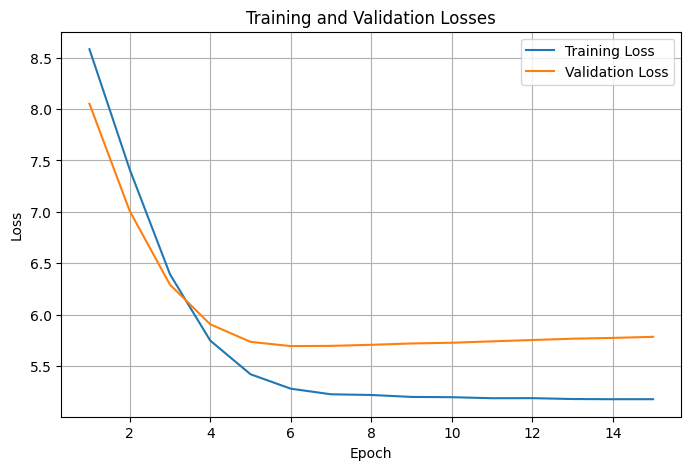

Test Loss: 5.6248


In [92]:
model_opt, train_losses, val_losses = training_val_seq2seq(
    model,
    train_dataloader,
    valid_dataloader,
    num_epochs,
    loss_fn,
    learning_rate,
    verbose=True
)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

test_loss = evaluate_seq2seq(model_opt, test_dataloader, loss_fn)

print(f"Test Loss: {test_loss:.4f}")

## Perspectives

Let's quickly check the results on one example from the test set.

In [105]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    en_vocab,
    de_vocab,
    sos_token='<sos>',
    eos_token='<eos>',
    device='cpu',
    output_length=15,
):
    model.eval()

    # prepare the input sentence (tokenization, numericalization)
    en_tokens = [token.text for token in en_nlp.tokenizer(sentence)]
    en_tokens = [token.lower() for token in en_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    ids = en_vocab.lookup_indices(en_tokens)
    tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)

    # Compute the translation using the model
    with torch.no_grad():
        outputs, _ = model(tensor, output_length)
        outputs = torch.argmax(outputs, -1)
    outputs = [x.item() for x in outputs]

    translated = de_vocab.lookup_tokens(outputs)

    return translated

In [106]:
# Get an example sentence and its translation
sentence = test_data[0]["en"]
true_translation = test_data[0]["de"]

# Get the true length of the (tokenized) translated sentence
trg_len = len([token.text for token in de_nlp.tokenizer(true_translation)])

# Translate the sentence
pred_translation = translate_sentence(
    sentence,
    model_opt,
    en_nlp,
    en_vocab,
    de_vocab,
    output_length=trg_len
)

print('Sentence:              ', sentence)
print('True translation:      ', true_translation)
print('Predicted translation: ', pred_translation)

Sentence:               A man in an orange hat starring at something.
True translation:       Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
Predicted translation:  ['<sos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


As you can see on the example above, the results are not satisfactory. This can be explained by a variety of factors, but mainly because we consider a very small subset of the data and because we used a very light network. We provide the pretrained weights of a model with larger hidden and embedding sizes, and trained on the whole dataset (you can reproduce it using the provided parameters and using a batch size of 128).

In [109]:
# Load the large pretrained model
model_large = torch.jit.load(pretrained_model_path)

# Translate the sentence
pred_translation = translate_sentence(
    sentence,
    model_large,
    en_nlp,
    en_vocab,
    de_vocab,
    output_length=trg_len
)

print('Sentence:              ', sentence)
print('True translation:      ', true_translation)
print('Predicted translation: ', pred_translation)

Sentence:               A man in an orange hat starring at something.
True translation:       Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
Predicted translation:  ['<sos>', 'ein', 'mann', 'mit', 'einem', 'kopfbedeckung', 'starrt', 'etwas', 'etwas', 'etwas', '.']


The results are much better with this larger network, although not perfect since both the network structure and training protocol are rather basic. There are many other strategies to improve this task's performance (but also many other text processing / NLP tasks based on RNNs - or not):

- using *bi-directionnal* recurrent networks to better account for the whole context of the sentence.
- *skip-filtering*, which means feeding each RNN cell with the whole context vector instead of just the previous hidden state (done [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb)).
- *teacher forcing* when training the decoder, which means using the ground truth token as input to each decoding step, instead of the predicted token from the previous step (done [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)).
- *packed padded sentences* with masking, which allows to skip the `<pad>` token in the encoder and save time (done [here](https://github.com/bentrevett/pytorch-seq2seq/blob/main/legacy/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb)).
- *self-attention*, a key component in [transformers](https://arxiv.org/pdf/1706.03762.pdf), which are state-of-the-art architectures for machine translation (see a simplified version implemented [here](https://github.com/bentrevett/pytorch-seq2seq/blob/main/legacy/6%20-%20Attention%20is%20All%20You%20Need.ipynb)).

And many more - research continues to advance!